In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
from conviction_helpers import *
from conviction_system_logic3 import *
from bonding_curve_eq import *

This notebook uses the differential games framework developed by BlockScience. It is currently in private beta, and building towards a full open source release.

**Description:**

cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

To learn more about cadCAD, follow our [tutorial series](https://github.com/BlockScience/cadCAD-Tutorials/tree/master/01%20Tutorials)

**Installing cadCAD:**

cadCAD is in private beta. Tokens are issued to participants. Replace `<TOKEN>` in the installation URL below
```bash
pip3 install cadCAD --extra-index-url https://<TOKEN>@repo.fury.io/blockscience/
```

If you'd like to participate in the beta program, contact cadcad [at] block [dot] science.


# Trigger Threshold
A Proposal always proposes to spend some funds on some activity.

The trigger threshold calculates how much conviction is needed for a proposal to pass.

Of course, that depends on the amount of funding requested, and how much is it in proportion to how much funds are left in the funding pool.

It also depends on the amount of tokens that exist right now (`supply`), because 100 tokens can only generate so much conviction, as compared to 100,000 tokens. So the algorithm should scale according to how much conviction one can expect to gather, given the amount of tokens that exist in the system.

With the parameter `beta = 0.2`, any proposal that requests 20% of the total funds available will never be able to pass.
Parameter rho tunes how quickly this "impossible" situation is reached.

In [2]:
#THIS policy is one of the main paramters of this system!

#maximum share of funds a proposal can take
default_beta = .2 #later we should set this to be param so we can sweep it
# tuning param for the trigger function
default_rho = .5*default_beta**2

def trigger_threshold(requested, funds, supply, beta=default_beta , rho=default_rho):
    
    share = requested/funds
    if share < beta:
        return rho*supply/(beta-share)**2
    else: 
        return np.inf

In [3]:
dict1 = trigger_sweep('token_supply',trigger_threshold)

Text(0.15940000000000001, 1008990000.0, 'fixed alpha = 0.5')

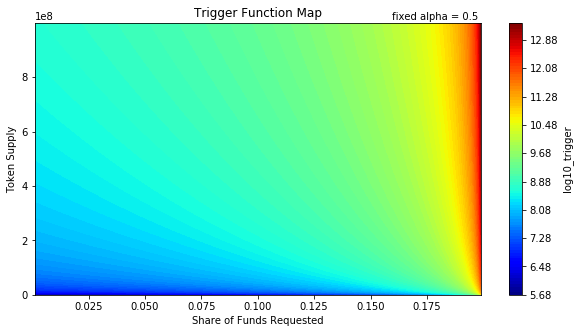

In [4]:
trigger_plotter(dict1['share_of_funds'],
                dict1['log10_trigger'], 
                'log10_trigger',
                dict1['total_supply'],
                'Token Supply')
axis = plt.axis()
plt.text(.2*axis[0]+.8*axis[1],axis[-1]*1.01, 'fixed alpha = 0.5')

In [5]:
dict2 = trigger_sweep('alpha',trigger_threshold)

In [6]:
dict2.keys()

dict_keys(['log10_trigger', 'trigger', 'share_of_max_conv', 'log10_share_of_max_conv', 'alpha', 'share_of_funds'])

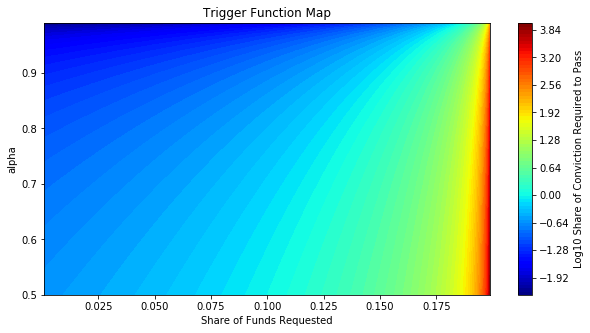

In [7]:
trigger_plotter(dict2['share_of_funds'],
                dict2['log10_share_of_max_conv'], 
                'Log10 Share of Conviction Required to Pass',
                dict2['alpha'],
                'alpha')


In [8]:
n= 60 #initial participants
m= 3 #initial proposals

initial_sentiment = .6

theta =.35
kappa = 6
sale_price = .1

def TFGTS(total_supply):
    #wrap initializer params to pass the function correctly
    return total_funds_given_total_supply(total_supply, theta = theta, initial_price = sale_price) 


# Initializers
Here we generate a social network of `n` simulated humans (participants). They have gathered some funds which will be split into the collateral pool (this pool of money backs part of the worth of the tokens) and the funding pool (this is where the money for activities comes from).

The percentage split of how much goes to the collateral pool and how much goes to the funding pool is `theta`.

Their faith in the project is represented by `initial_sentiment`. As faith goes down, they will sell out and add to the funding pool through the exit tribute.



In [9]:
#initializers
network, initial_funds, initial_supply, total_requested = initialize_network(n,m,TFGTS,trigger_threshold)
initial_reserve, invariant, initial_price= initialize_bonding_curve(initial_supply, initial_price = sale_price, kappa =kappa, theta = theta)

# Invariant
This number describes the relationship of how much of each token is backed by actual money in the collateral pool.

It is a ratio of:

tokens in existence : funds in backing collateral pool

In [10]:
invariant

1.2081031389476284e+31

In [11]:
proposals = get_nodes_by_type(network, 'proposal')
participants = get_nodes_by_type(network, 'participant')

supporters = get_edges_by_type(network, 'support')
influencers = get_edges_by_type(network, 'influence')
competitors = get_edges_by_type(network, 'conflict')

In [12]:
initial_reserve

61932.246048945904

In [13]:
initial_funds

33348.13248789395

In [14]:
#sample proposal
network.nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 11828.671935063441,
 'trigger': inf}

In [15]:
#sample participant
network.nodes[participants[0]]

{'type': 'participant',
 'holdings': 28148.234914796605,
 'sentiment': 0.8226063490532288}

In [16]:
#sample relationship participant to proposal
network.edges[supporters[0]]

{'affinity': 0.6200194762806283,
 'tokens': 0,
 'conviction': 0,
 'type': 'support'}

In [17]:
network.edges[influencers[0]]

{'influence': 4.698641587709733, 'type': 'influence'}

In [18]:
network.edges[competitors[0]]

{'conflict': 0.9647956742306406, 'type': 'conflict'}

Text(0.5, 1.0, 'Participants Social Network')

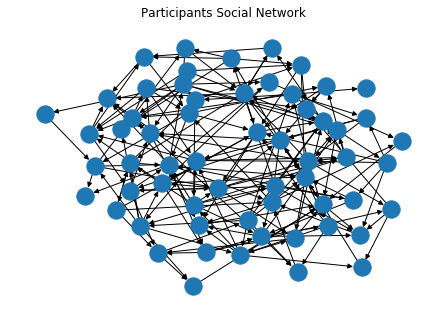

In [19]:
nx.draw_kamada_kawai(network, nodelist = participants, edgelist=influencers)
plt.title('Participants Social Network')

## The nodes in this graph are the participants, and the edges represent their influence on one another.

Text(0.5, 1.0, 'Proposals Conflict Network')

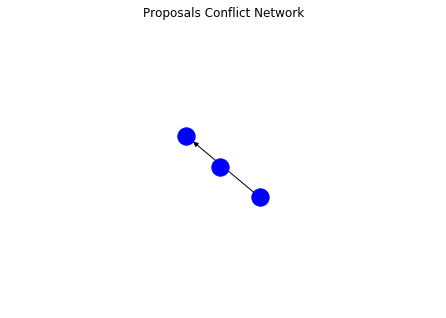

In [20]:
nx.draw_kamada_kawai(network, nodelist = proposals, edgelist=competitors, node_color='b')
plt.title('Proposals Conflict Network')

Text(0.5, 1.0, 'Histogram of Participants Token Holdings')

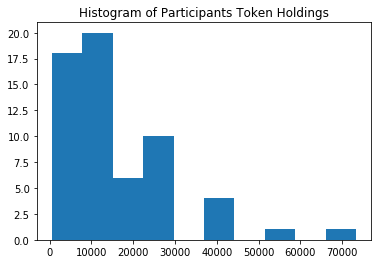

In [21]:
plt.hist([ network.nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')

## Here you have 18 people with very few tokens, and 4 people with a lot of tokens.

Text(0.5, 1.0, 'Histogram of Proposals Funds Requested')

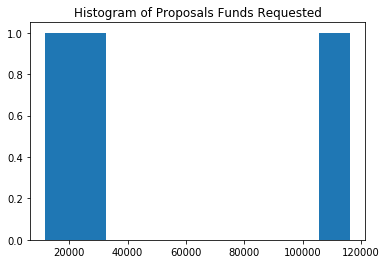

In [22]:
plt.hist([ network.nodes[i]['funds_requested'] for i in proposals])
plt.title('Histogram of Proposals Funds Requested')

## There are 3 proposals - 2 of which want to spend 15000 and the other 35000

In [23]:
affinities = np.empty((n,m))
for i_ind in range(n):
    for j_ind in range(m):
        i = participants[i_ind]
        j = proposals[j_ind]
        affinities[i_ind][j_ind] = network.edges[(i,j)]['affinity']

Text(0.5, 137.58, 'participant_id')

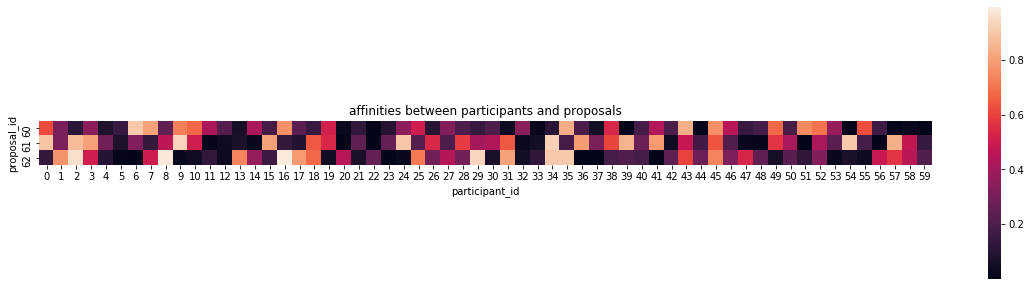

In [24]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=participants,
            yticklabels=proposals,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

## This chart shows how much each participant liked each proposal

In [25]:
#power of 1 token forever
conviction_capacity = [2,5,10]
alpha = [1-1/cc for cc in conviction_capacity]
print(alpha)

[0.5, 0.8, 0.9]


In [26]:
params= {
    'sensitivity': [.75],
    'tmin': [7], #unit days; minimum periods passed before a proposal can pass
    'min_supp':[50], #number of tokens that must be stake for a proposal to be a candidate
    'sentiment_decay': [.01], #termed mu in the state update function
    'alpha': alpha,
    'base_completion_rate': [100],
    'base_failure_rate': [200],
    'trigger_func': [trigger_threshold],
    'kappa': [kappa], #bonding curve curvature
    'invariant': [invariant], #set by bonding curve choices
    'tax_rate': [.02]
    }

In [27]:
type(trigger_threshold)

function

In [28]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
time_periods_per_run = 100
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [29]:
simulation_parameters

[{'N': 1,
  'T': range(0, 100),
  'M': {'sensitivity': 0.75,
   'tmin': 7,
   'min_supp': 50,
   'sentiment_decay': 0.01,
   'alpha': 0.5,
   'base_completion_rate': 100,
   'base_failure_rate': 200,
   'trigger_func': <function __main__.trigger_threshold(requested, funds, supply, beta=0.2, rho=0.020000000000000004)>,
   'kappa': 6,
   'invariant': 1.2081031389476284e+31,
   'tax_rate': 0.02}},
 {'N': 1,
  'T': range(0, 100),
  'M': {'sensitivity': 0.75,
   'tmin': 7,
   'min_supp': 50,
   'sentiment_decay': 0.01,
   'alpha': 0.8,
   'base_completion_rate': 100,
   'base_failure_rate': 200,
   'trigger_func': <function __main__.trigger_threshold(requested, funds, supply, beta=0.2, rho=0.020000000000000004)>,
   'kappa': 6,
   'invariant': 1.2081031389476284e+31,
   'tax_rate': 0.02}},
 {'N': 1,
  'T': range(0, 100),
  'M': {'sensitivity': 0.75,
   'tmin': 7,
   'min_supp': 50,
   'sentiment_decay': 0.01,
   'alpha': 0.9,
   'base_completion_rate': 100,
   'base_failure_rate': 200,
   '

In [30]:
initial_conditions = {'network':network,
                      'supply': initial_supply,
                      'funds':initial_funds,
                      'reserve': initial_reserve,
                      'spot_price': initial_price,
                      'sentiment': initial_sentiment}

In [31]:
initial_conditions

{'network': <networkx.classes.digraph.DiGraph at 0x7feb59ed5700>,
 'supply': 952803.7853683985,
 'funds': 33348.13248789395,
 'reserve': 61932.246048945904,
 'spot_price': 0.3900000000000004,
 'sentiment': 0.6}

In [32]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': driving_process
        },
        'variables': {
            'network': update_network,
            'funds':increment_funds,
            'supply':increment_supply,
            'reserve': increment_reserve
        }
    },
    {
      'policies': {
          'completion': check_progress #see if any of the funded proposals completes
        },
        'variables': { # The following state variables will be updated simultaneously
            'sentiment': update_sentiment_on_completion, #note completing decays sentiment, completing bumps it
            'network': complete_proposal #book-keeping
        }
    },
        {
      'policies': {
          'release': trigger_function #check each proposal to see if it passes
        },
        'variables': { # The following state variables will be updated simultaneously
            'funds': decrement_funds, #funds expended
            'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
            'network': update_proposals #reset convictions, and participants sentiments
                                        #update based on affinities
        }
    },
    { 
        'policies': { 
            #currently naive decisions; future: strategic
            'participants_act': participants_decisions, #high sentiment, high affinity =>buy
                                                        #low sentiment, low affinities => burn
                                                        #assign tokens to top affinities
        },
        'variables': {
            'supply': update_supply, #book-keeping from participants decisions
            'reserve': update_reserve, #funds under the bonding curve
            'spot_price': update_price, #new bonding curve spot price
            'funds': update_funds, #capture taxes
            'network': update_tokens #update everyones holdings 
                                    #and their conviction for each proposal
        }
    }
]

In [33]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.5, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x7feb5d0e85e0>, 'kappa': 6, 'invariant': 1.2081031389476284e+31, 'tax_rate': 0.02}}, {'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.8, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x7feb5d0e85e0>, 'kappa': 6, 'invariant': 1.2081031389476284e+31, 'tax_rate': 0.02}}, {'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.9, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x7feb5d0e85e0>, 'kappa': 6, 'invariant': 1.2081031389476284e+31, 'tax_rate': 0.02}}]
[{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, '

In [34]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [35]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7feb59bb4220>, <cadCAD.configuration.Configuration object at 0x7feb59bb4340>, <cadCAD.configuration.Configuration object at 0x7feb59b07100>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7feb59bb4220>, <cadCAD.configuration.Configuration object at 0x7feb59bb4340>, <cadCAD.configuration.Configuration object at 0x7feb59b07100>]


In [36]:
params['kappa']

[6]

In [37]:
params

{'sensitivity': [0.75],
 'tmin': [7],
 'min_supp': [50],
 'sentiment_decay': [0.01],
 'alpha': [0.5, 0.8, 0.9],
 'base_completion_rate': [100],
 'base_failure_rate': [200],
 'trigger_func': [<function __main__.trigger_threshold(requested, funds, supply, beta=0.2, rho=0.020000000000000004)>],
 'kappa': [6],
 'invariant': [1.2081031389476284e+31],
 'tax_rate': [0.02]}

{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.5, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x7feb5d0e85e0>, 'kappa': 6, 'invariant': 1.2081031389476284e+31, 'tax_rate': 0.02}}


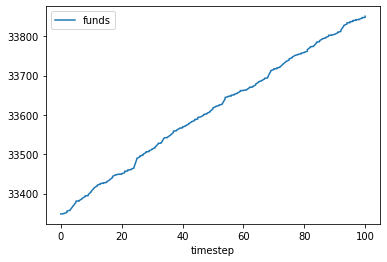

{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.8, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x7feb5d0e85e0>, 'kappa': 6, 'invariant': 1.2081031389476284e+31, 'tax_rate': 0.02}}


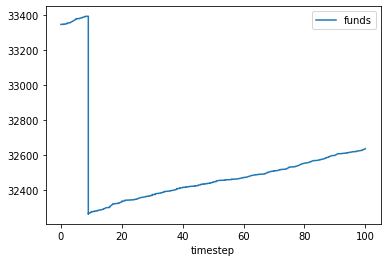

{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.9, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x7feb5d0e85e0>, 'kappa': 6, 'invariant': 1.2081031389476284e+31, 'tax_rate': 0.02}}


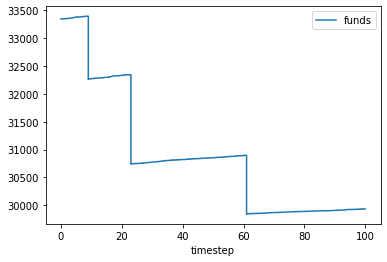

In [38]:
for ind in range(len(results)):
    r=results[ind]['result']
    print(results[ind]['simulation_parameters'])
    r.plot(x='timestep', y='funds')
    plt.show()

## Explanation
In the first graph, people kept losing faith in the organization, and sold out. Through the exit tribute, their money goes into the funding pool, but no proposals were passed that might have spent those funds.

In the second graph, people are still constantly selling out of the organization, but at least some proposals are passed.

In the third graph, people believe in the organization and never sell out, but so many proposals are being passed that the funding pool is shrinking.

# Let's look closer at the 3rd graph

In [39]:
#I ran multiple experiments above, pick1
experiment_index = 2
df = results[experiment_index]['result']

In [40]:
df['conviction'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['killed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='killed']))
df['killed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='killed']))
df['candidate_funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['active_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['active_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['failed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='failed']))
df['failed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='failed']))
df['completed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))
df['completed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))

In [41]:
df['funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal')]))
df['share_of_funds_requested'] = df.candidate_funds_requested/df.funds

df['share_of_funds_requested_all'] = df.funds_requested/df.funds

In [42]:
df['triggers'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))
df['conviction_share_of_trigger'] = df.conviction/df.triggers
df['age'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))

In [43]:
df['age_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') ]))
df['conviction_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') ]))
df['triggers_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal')  ]))

df['conviction_share_of_trigger_all'] = df.conviction_all/df.triggers_all

In [44]:
rdf= df[df.substep==4].copy()

In [45]:
df[['funds','supply', 'reserve','spot_price']].head(10)

funds         supply       reserve  spot_price
0  33348.132488  952803.785368  61932.246049    0.390000
1  33348.609441  952803.785368  61932.246049    0.390000
2  33348.609441  952803.785368  61932.246049    0.390000
3  33348.609441  952803.785368  61932.246049    0.390000
4  33349.475235  952730.847884  61903.805873    0.389851
5  33351.621891  952730.847884  61903.805873    0.389851
6  33351.621891  952730.847884  61903.805873    0.389851
7  33351.621891  952730.847884  61903.805873    0.389851
8  33355.347309  952321.730775  61744.482387    0.389014
9  33357.061564  952321.730775  61744.482387    0.389014

In [46]:
print(params['invariant'])
df['invar'] = df.supply**kappa/df.reserve
df.invar.head(10)

[1.2081031389476284e+31]


0    1.208103e+31
1    1.208103e+31
2    1.208103e+31
3    1.208103e+31
4    1.208103e+31
5    1.208103e+31
6    1.208103e+31
7    1.208103e+31
8    1.208103e+31
9    1.208103e+31
Name: invar, dtype: float64

In [47]:
df[['supply', 'reserve','spot_price']].head(10).diff()

supply       reserve  spot_price
0         NaN           NaN         NaN
1    0.000000 -7.275958e-12    0.000000
2    0.000000  0.000000e+00    0.000000
3    0.000000  0.000000e+00    0.000000
4  -72.937485 -2.844018e+01   -0.000149
5    0.000000  0.000000e+00    0.000000
6    0.000000  0.000000e+00    0.000000
7    0.000000  0.000000e+00    0.000000
8 -409.117109 -1.593235e+02   -0.000836
9    0.000000  0.000000e+00    0.000000

Text(0.5, 1.0, 'Summary of Local Economy')

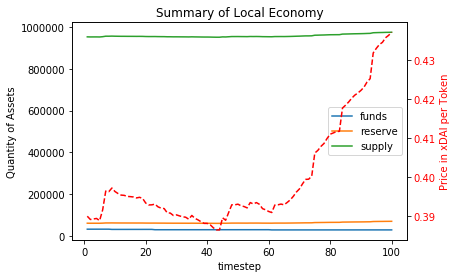

In [48]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

rdf.plot(x='timestep', y=['funds', 'reserve','supply'], ax=ax1)
rdf.plot(x='timestep', y='spot_price',style='--',color = 'red', ax=ax2, legend = False)
ax2.set_ylabel('Price in xDAI per Token', color='red')
ax1.set_ylabel('Quantity of Assets')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Summary of Local Economy')

# The token supply keeps increasing, which means more people are buying into the organization. The token price accordingly goes up (dashed line). The collateral pool (reserve) goes up slightly, but the amount of money in the funding pool has actually gone down a bit.

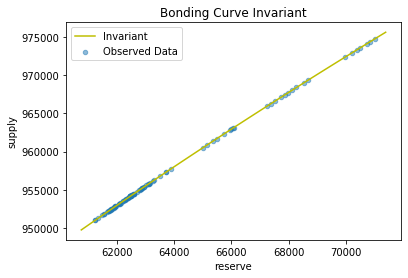

In [49]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, invariant, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

# The bonding curve appears to be working correctly.

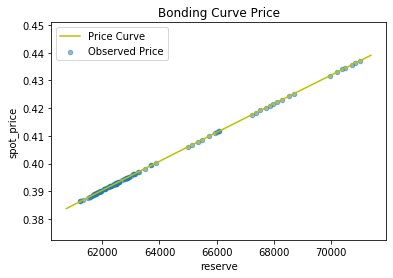

In [50]:
rdf.plot(x='reserve', y='spot_price', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([spot_price(x, invariant, kappa) for x in xrange ])

plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Price')
plt.legend(['Price Curve', 'Observed Price'])

In [51]:
last_net= df.network.values[-1]
last_props=get_nodes_by_type(last_net, 'proposal')
M = len(last_props)
last_parts=get_nodes_by_type(last_net, 'participant')
N = len(last_parts)

In [52]:
affinities = np.empty((N,M))
for i_ind in range(N):
    for j_ind in range(M):
        i = last_parts[i_ind]
        j = last_props[j_ind]
        affinities[i_ind][j_ind] = last_net.edges[(i,j)]['affinity']

Text(0.5, 113.52077922077922, 'participant_id')

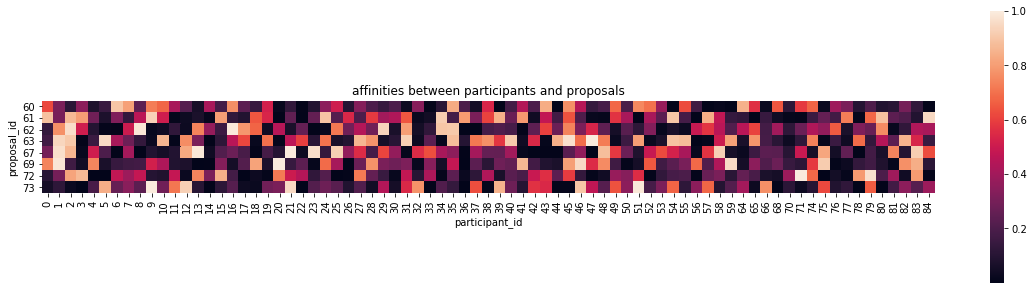

In [53]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=last_parts,
            yticklabels=last_props,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

# More participants have joined, because so many people believe in it. This is how much they liked each proposal.

In [54]:
#working on deduplicating colors
#
#last_props=get_nodes_by_type(last_net, 'proposal')
#M = len(last_props)

#cm = plt.get_cmap('gist_rainbow')
#c= [cm(1.*j/M) for j in range(M)] 

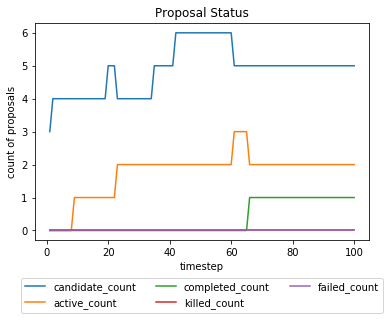

In [55]:
rdf.plot(x='timestep',y=['candidate_count','active_count','completed_count', 'killed_count', 'failed_count'])
plt.title('Proposal Status')
plt.ylabel('count of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

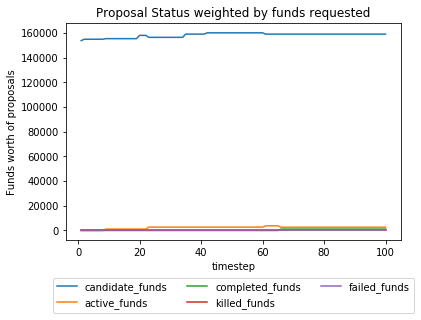

In [56]:
rdf.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds', 'killed_funds', 'failed_funds'])
plt.title('Proposal Status weighted by funds requested')
plt.ylabel('Funds worth of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

Text(0, 0.5, 'share_of_funds_requested')

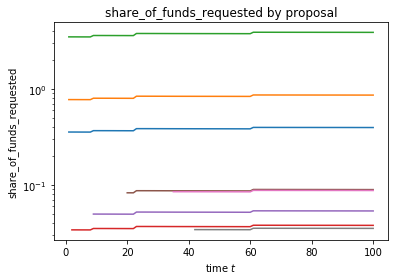

In [57]:
plt.semilogy(rdf.timestep,make2D('share_of_funds_requested_all', rdf))
plt.title('share_of_funds_requested by proposal')
plt.xlabel('time $t$')
plt.ylabel('share_of_funds_requested')

Text(0.5, 0, 'share_of_funds_requested')

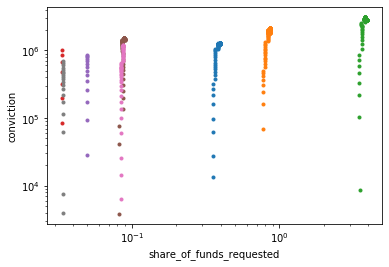

In [58]:
plt.loglog(make2D('share_of_funds_requested_all', rdf), make2D('conviction_all', rdf), '.')
plt.ylabel('conviction')
plt.xlabel('share_of_funds_requested')

Text(0.5, 0, 'proposal_age')

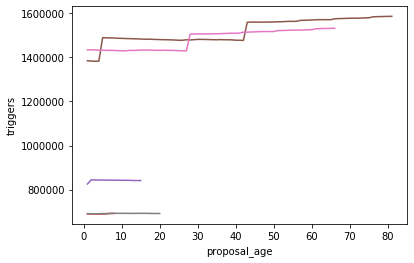

In [59]:
plt.plot(make2D('age_all', rdf), make2D('triggers_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')

Text(0.5, 1.0, 'phase: Triggers & Conviction')

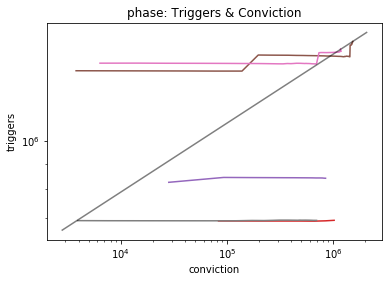

In [60]:
plt.loglog(make2D('conviction_all', rdf), make2D('triggers_all', rdf))
a = plt.axis()
plt.loglog(a[:2],a[2:], 'k',alpha=.5 )
plt.ylabel('triggers')
plt.xlabel('conviction')
plt.title('phase: Triggers & Conviction')

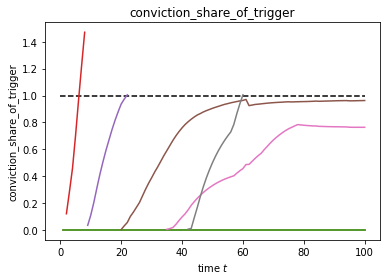

In [61]:
T = time_periods_per_run
plt.plot(rdf.timestep,make2D('conviction_share_of_trigger_all', rdf))
plt.title('conviction_share_of_trigger')
plt.xlabel('time $t$')
plt.ylabel('conviction_share_of_trigger')
plt.hlines(1,0,T, linestyle='--')

In [62]:
noplt.semilogy(make2D('age_all', rdf), make2D('conviction_share_of_trigger_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')
plt.hlines(1,0,T, linestyle='--')

NameError: name 'noplt' is not defined

In [63]:
nets = rdf.network.values

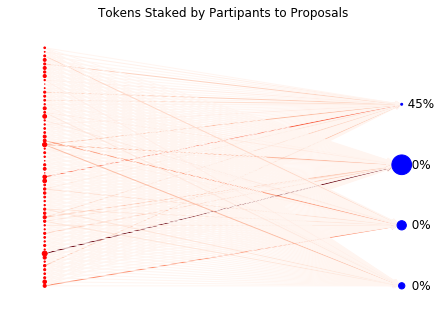

In [64]:
K = 3
snap_plot(nets[K:K+1], size_scale = 1/300)

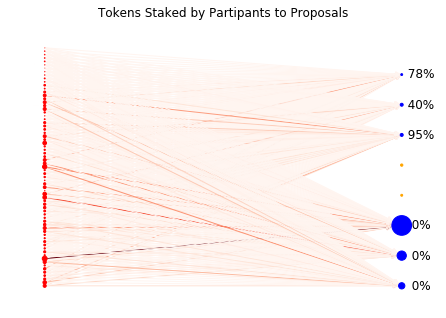

In [65]:
K = 56
snap_plot(nets[K:K+1], size_scale = 1/300)

In [69]:
def quantile_plot(xkey, ykey, dataframe, dq=.1, logy=False, return_df = False):
    qX = np.arange(0,1+dq,dq)
    
    data = dataframe[[xkey,ykey]].copy()
    
    qkeys = []
    for q in qX:
        qkey= 'quantile'+str(int(100*q))
        #print(qkey)
        data[qkey] = data[ykey].apply(lambda arr: np.quantile(arr,q) )
        #print(data[qkey].head())
        qkeys.append(qkey)
    
    data[[xkey]+qkeys].plot(x=xkey,  logy=logy)
        
    plt.title(ykey + " Quantile Plot" )
    plt.ylabel(ykey)
    labels = [str(int(100*q))+"$^{th}$ Percentile" for q in qX ]
    
    plt.legend(labels, ncol = 1,loc='center left', bbox_to_anchor=(1, .5))
    if return_df:
        return data

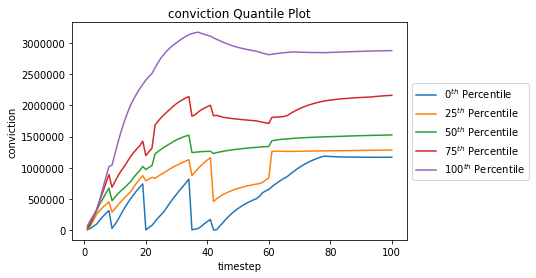

In [70]:
quantile_plot('timestep','conviction', rdf, .25)


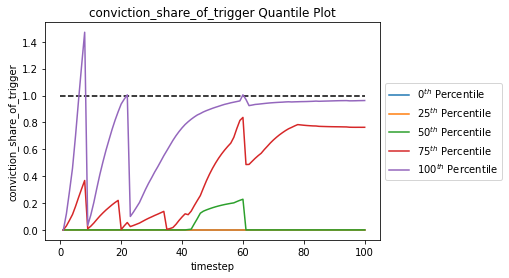

In [71]:
quantile_plot('timestep','conviction_share_of_trigger', rdf, .25)
plt.hlines(1,0,T, linestyle='--')